In [1]:
import pandas as pd

In [8]:


crew_data = pd.read_csv("../data/crew_data.csv")

# Inspect the first few rows of the dataframe
crew_data.head()

# Check the structure of the dataframe
crew_data.info()

# Display the column names to verify
print(crew_data.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5313 entries, 0 to 5312
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Crew_ID      5313 non-null   object
 1   task_ID      5313 non-null   object
 2   task_Name    5313 non-null   object
 3   Floor_No     5313 non-null   int64 
 4   Gate_number  5313 non-null   int64 
 5   Shift_No     5313 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 249.2+ KB
Index(['Crew_ID', 'task_ID', 'task_Name', 'Floor_No', 'Gate_number',
       'Shift_No'],
      dtype='object')


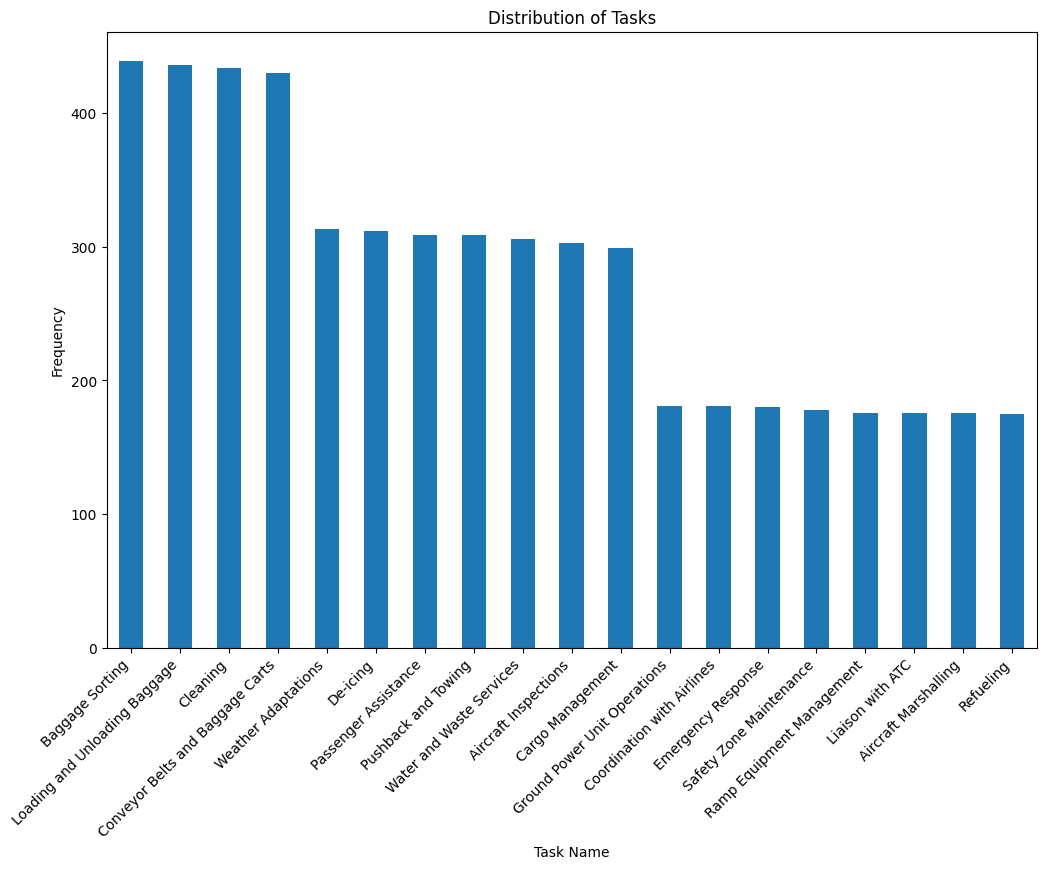

task_Name
Baggage Sorting                     439
Loading and Unloading Baggage       436
Cleaning                            434
Conveyor Belts and Baggage Carts    430
Weather Adaptations                 313
De-icing                            312
Passenger Assistance                309
Pushback and Towing                 309
Water and Waste Services            306
Aircraft Inspections                303
Cargo Management                    299
Ground Power Unit Operations        181
Coordination with Airlines          181
Emergency Response                  180
Safety Zone Maintenance             178
Ramp Equipment Management           176
Liaison with ATC                    176
Aircraft Marshalling                176
Refueling                           175
Name: count, dtype: int64

In [10]:
# Task Distribution Analysis

# Count the occurrences of each task
task_distribution = crew_data['task_Name'].value_counts()

# Plot the distribution of tasks
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
task_distribution.plot(kind='bar')
plt.title('Distribution of Tasks')
plt.xlabel('Task Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

# Display the task distribution
task_distribution

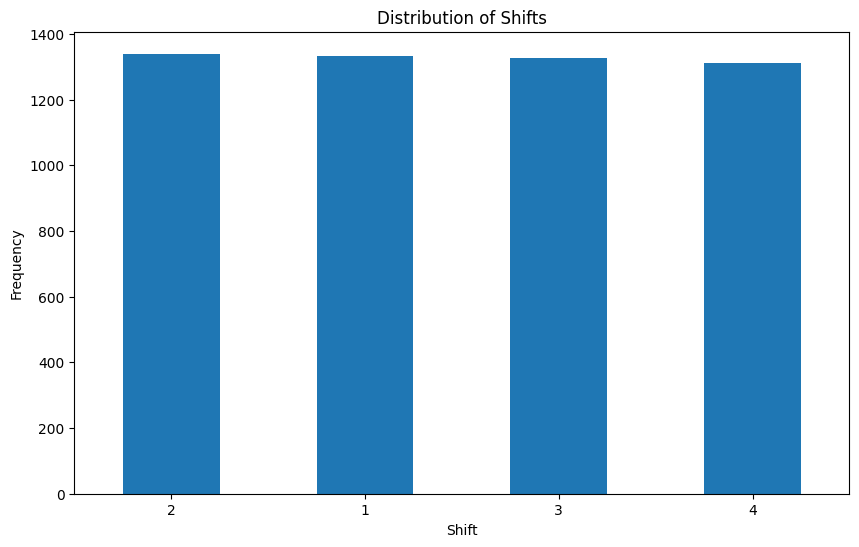

Shift_No
2    1340
1    1333
3    1327
4    1313
Name: count, dtype: int64

In [15]:
# Shift Pattern Analysis

# Count the occurrences of each shift
shift_distribution = crew_data['Shift_No'].value_counts()

# Plot the distribution of shifts
plt.figure(figsize=(10, 6))
shift_distribution.plot(kind='bar')
plt.title('Distribution of Shifts')
plt.xlabel('Shift')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# Display the shift distribution
shift_distribution





In [1]:
# Load required libraries and data
import pandas as pd
import numpy as np
from pulp import *


In [2]:

import pandas as pd
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value

def optimize_task_allocation(predictions_df):
    # Create optimization model
    model = LpProblem("Task_Reallocation", LpMinimize)
    
    # Get unique values
    tasks = predictions_df['Task_ID'].unique()
    gates = predictions_df['Gate_number'].unique()
    shifts = predictions_df['Shift_no'].unique()
    
    # Decision variables
    # Allow integer allocation to match actual demand
    assignments = LpVariable.dicts(
        "assign",
        ((t, g, s) for t in tasks for g in gates for s in shifts),
        lowBound=0,  # Ensure no negative allocation
        cat='Integer'
    )

    # Objective: Minimize total crew deviations
    model += lpSum(
        assignments[t, g, s] * abs(predictions_df[
            (predictions_df['Task_ID'] == t) &
            (predictions_df['Gate_number'] == g) &
            (predictions_df['Shift_no'] == s)]['Predicted'].values[0])
        for t in tasks for g in gates for s in shifts
        if predictions_df[
            (predictions_df['Task_ID'] == t) &
            (predictions_df['Gate_number'] == g) &
            (predictions_df['Shift_no'] == s)]['Predicted'].values[0] > 0
    )

    # Constraints
    # Match the exact demand or surplus for each prediction
    for t in tasks:
        for g in gates:
            for s in shifts:
                predicted_value = predictions_df[
                    (predictions_df['Task_ID'] == t) &
                    (predictions_df['Gate_number'] == g) &
                    (predictions_df['Shift_no'] == s)
                ]['Predicted'].values[0]
                
                if predicted_value > 0:
                    # Ensure allocation matches demand
                    model += assignments[t, g, s] == predicted_value
                elif predicted_value <= 0:
                    # Ensure no allocation for surplus or zero
                    model += assignments[t, g, s] == 0

    # Solve the model
    model.solve()
    
    # Extract results
    results = []
    for t in tasks:
        for g in gates:
            for s in shifts:
                allocated = value(assignments[t, g, s])
                if allocated is not None and allocated > 0:
                    results.append({
                        'Task_ID': t,
                        'Gate_number': g,
                        'Shift_no': s,
                        'Allocated': allocated
                    })
    
    return pd.DataFrame(results)
# Example usage
predictions_df = pd.read_csv('../data/predictions_final.csv')  # Assuming you have a predictions.csv file
optimized_allocation = optimize_task_allocation(predictions_df)
print(optimized_allocation)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ananyabhat/Documents/mainel/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/lf/c5b_4d3s14x09yk32w_qxhdh0000gn/T/3dced10f4a4549e1ade7851508f47784-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/lf/c5b_4d3s14x09yk32w_qxhdh0000gn/T/3dced10f4a4549e1ade7851508f47784-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2513 COLUMNS
At line 10776 RHS
At line 13285 BOUNDS
At line 15794 ENDATA
Problem MODEL has 2508 rows, 2508 columns and 2508 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2832 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 2832 to -1.79769e+308
Probing was tried 0 times an

In [3]:

# Load and process data
predictions_df = pd.read_csv('../data/predictions_final.csv')
optimized_allocation = optimize_task_allocation(predictions_df)

# Save results
optimized_allocation.to_csv('optimized_task_allocation.csv', index=False)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ananyabhat/Documents/mainel/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/lf/c5b_4d3s14x09yk32w_qxhdh0000gn/T/4c9ceeb70f8e4bbdaec942a2b41772e5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/lf/c5b_4d3s14x09yk32w_qxhdh0000gn/T/4c9ceeb70f8e4bbdaec942a2b41772e5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2513 COLUMNS
At line 10776 RHS
At line 13285 BOUNDS
At line 15794 ENDATA
Problem MODEL has 2508 rows, 2508 columns and 2508 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2832 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 2832 to -1.79769e+308
Probing was tried 0 times an

In [4]:

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Set the float format to display whole numbers
pd.options.display.float_format = '{:.0f}'.format

# Create the pivot table
pivot_table = optimized_allocation.pivot_table(
    values='Allocated',
    index='Task_ID',
    columns='Shift_no',
    aggfunc='first'
)

# Print the pivot table
print("Optimized Task Allocation by Shift:")
print(pivot_table)

# Reset the float format if needed (optional)
pd.reset_option('display.float_format')

# Adjust the DataFrame display settings
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Expand the display width to fit the DataFrame

# Ensure all values are displayed as integers in the DataFrame
optimized_allocation['Allocated'] = optimized_allocation['Allocated'].astype(int)

# Print the DataFrame
print(optimized_allocation)


Optimized Task Allocation by Shift:
Shift_no  1  2  3  4
Task_ID             
T-001     2  1  2  1
T-002     3  1  1  1
T-003     2  1  1  1
T-004     2  3  3  1
T-005     2  1  2  2
T-006     2  2  2  2
T-007     1  1  1  2
T-008     3  2  3  2
T-009     3  2  2  2
T-010     2  1  1  1
T-011     1  3  2  3
T-012     1  1  1  1
T-013     3  2  1  1
T-014     2  1  3  1
T-015     1  2  3  1
T-016     2  2  2  1
T-017     3  1  3  3
T-018     4  1  3  1
T-019     1  3  1  2
    Task_ID  Gate_number  Shift_no  Allocated
0     T-004           39         3          3
1     T-004           35         3          1
2     T-004           35         1          2
3     T-004           35         2          3
4     T-004           31         3          2
5     T-004           31         1          2
6     T-004           40         3          2
7     T-004           28         3          2
8     T-004           28         2          1
9     T-004           30         3          2
10    T-004      

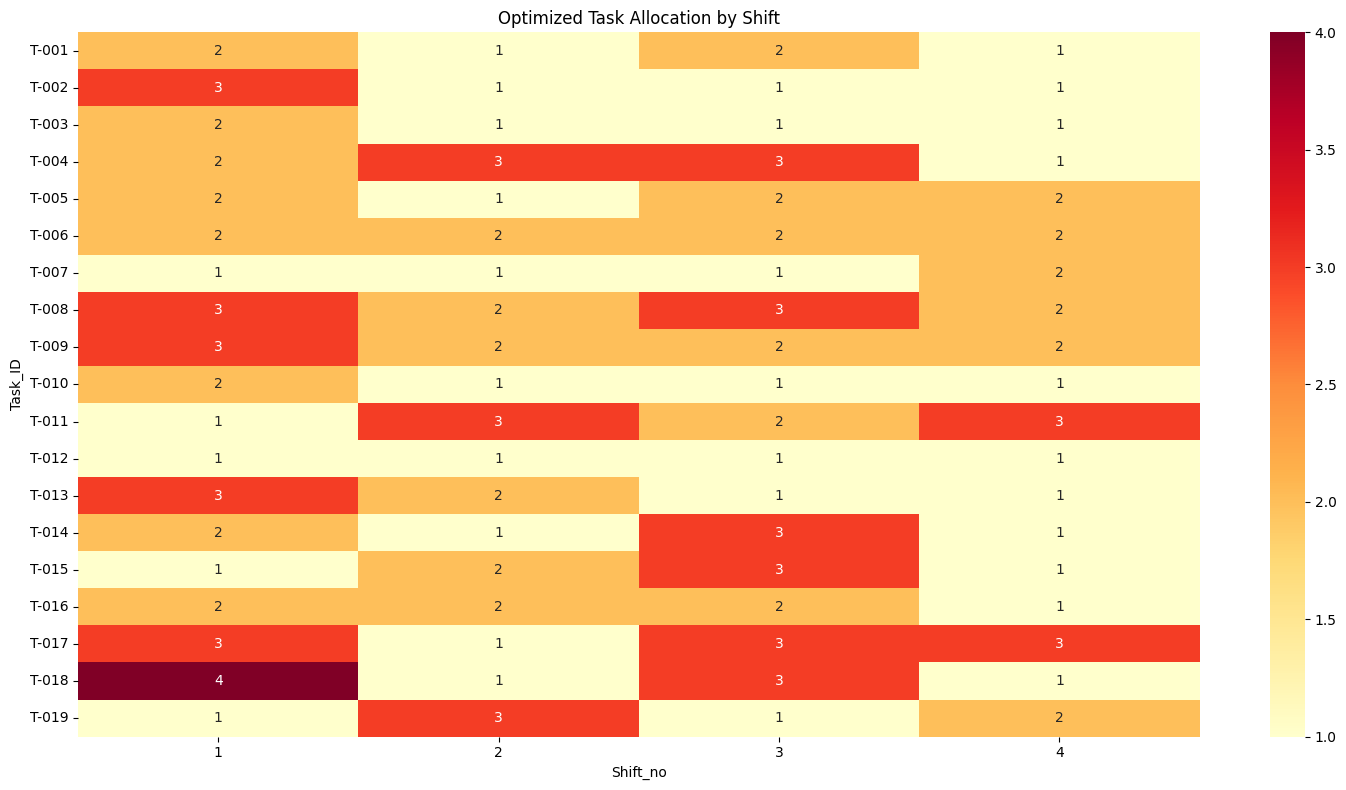

In [6]:

plt.figure(figsize=(15, 8))
pivot_table = optimized_allocation.pivot_table(
    values='Allocated',
    index='Task_ID',
    columns='Shift_no',
    aggfunc='first'
)
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True)
plt.title('Optimized Task Allocation by Shift')
plt.tight_layout()
plt.show()

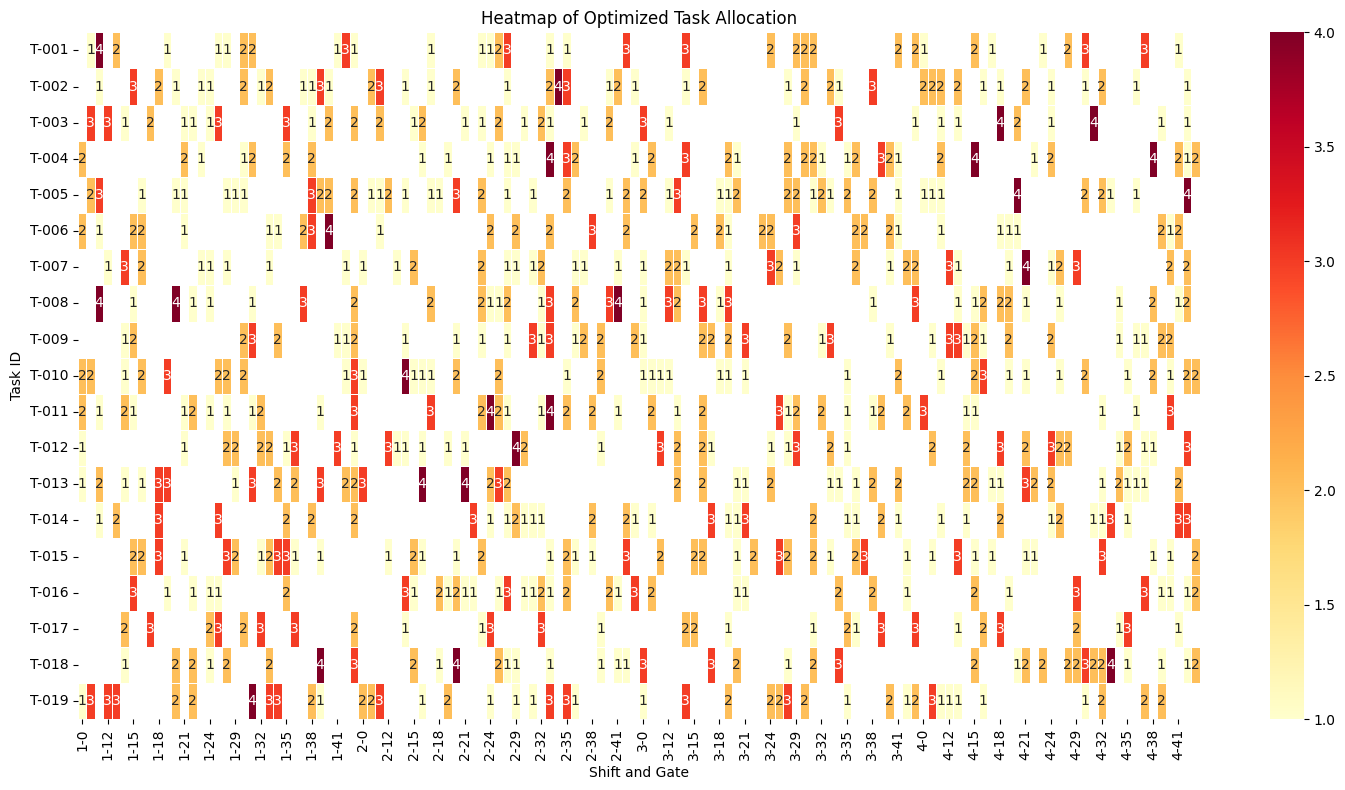

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Pivot the DataFrame to prepare it for heatmap
heatmap_data = optimized_allocation.pivot_table(
    values='Allocated', 
    index='Task_ID', 
    columns=['Shift_no', 'Gate_number'],  # Optional: Add Gate_number if needed
    aggfunc='first'  # Ensures no aggregation if combinations are unique
)

# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt=".0f", linewidths=0.5)  # Changed fmt to ".0f"
plt.title('Heatmap of Optimized Task Allocation')
plt.xlabel('Shift and Gate')
plt.ylabel('Task ID')
plt.tight_layout()
plt.show()


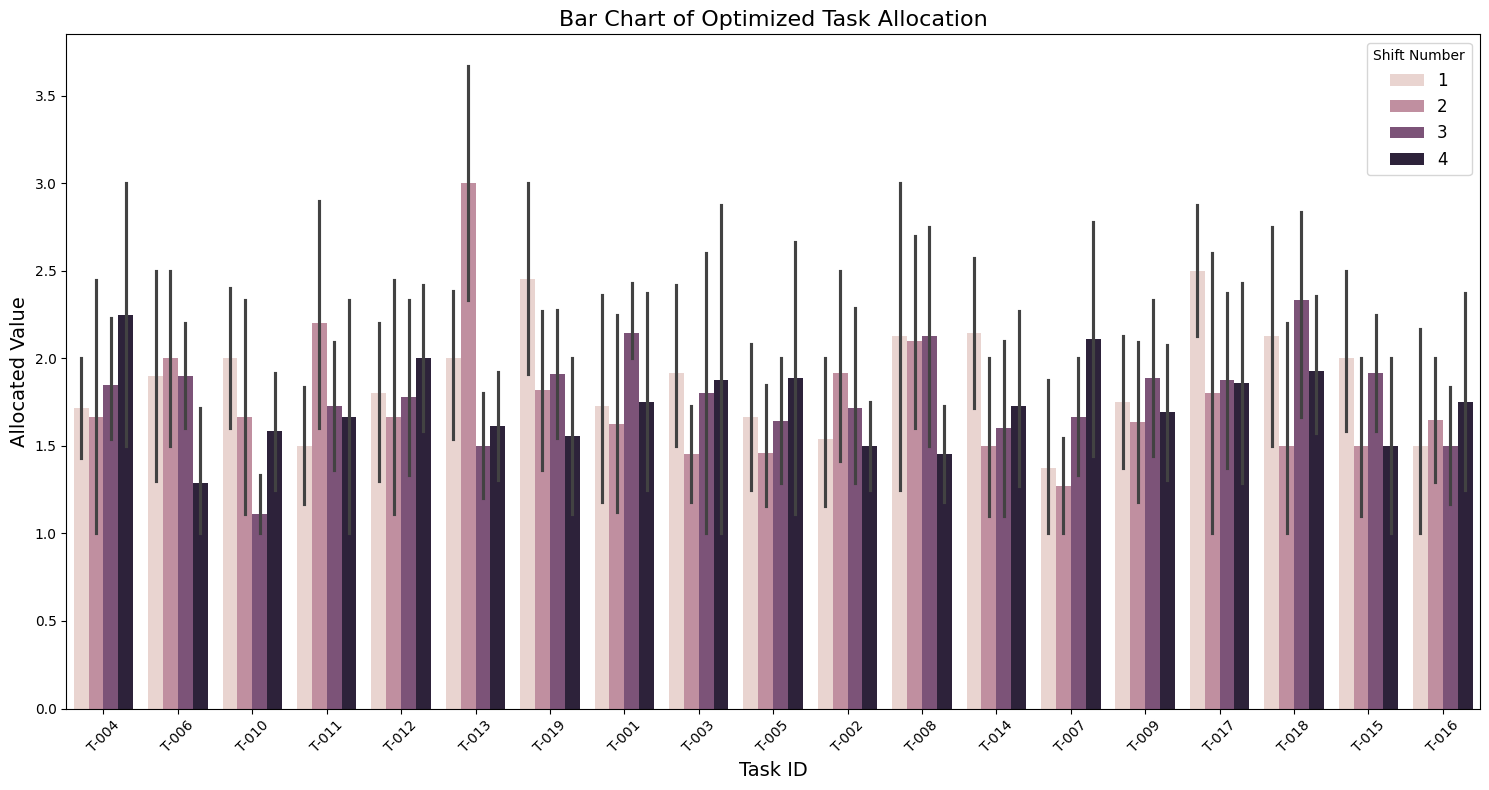

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Prepare data for the bar chart
bar_chart_data = optimized_allocation.groupby(['Shift_no', 'Gate_number', 'Task_ID'])['Allocated'].sum().reset_index()

# Create a bar chart
plt.figure(figsize=(15, 8))
sns.barplot(
    data=bar_chart_data,
    x='Task_ID',
    y='Allocated',
    hue='Shift_no',  # Differentiate bars by shift numbers
    dodge=True  # Separate bars by 'Shift_no'
)

# Customize the chart
plt.title('Bar Chart of Optimized Task Allocation', fontsize=16)
plt.xlabel('Task ID', fontsize=14)
plt.ylabel('Allocated Value', fontsize=14)
plt.xticks(rotation=45)  # Rotate Task_ID labels for readability
plt.legend(title='Shift Number', fontsize=12)
plt.tight_layout()
plt.show()


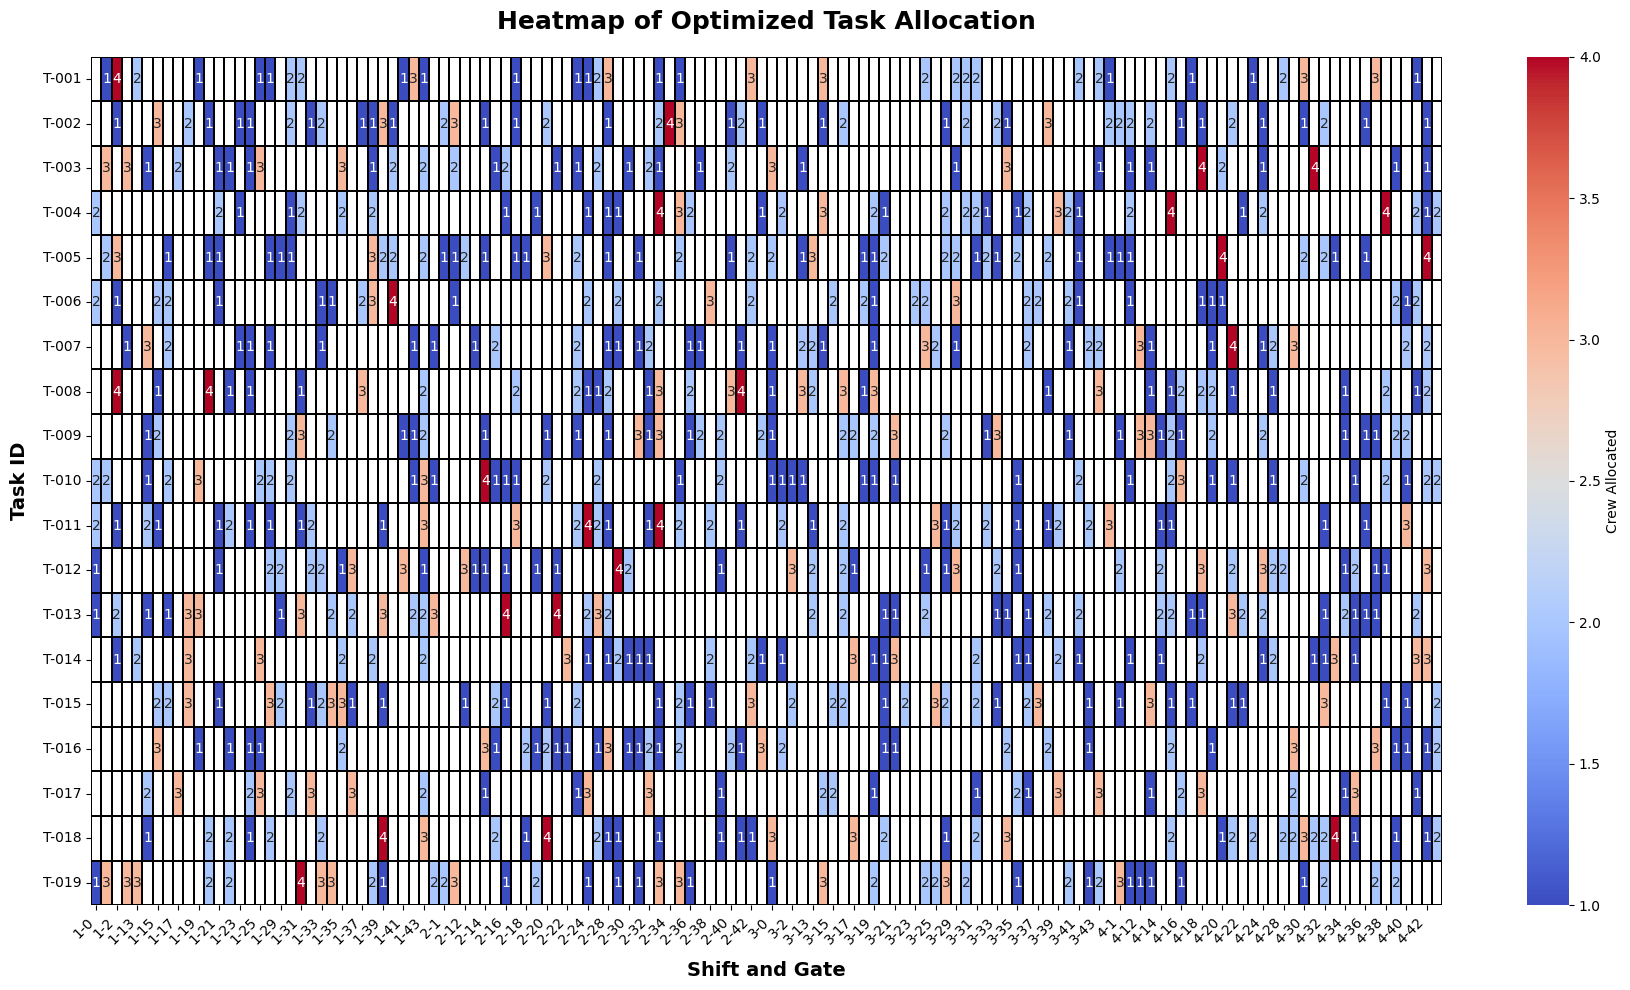

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Pivot the DataFrame to prepare it for heatmap
heatmap_data = optimized_allocation.pivot_table(
    values='Allocated', 
    index='Task_ID', 
    columns=['Shift_no', 'Gate_number'], 
    aggfunc='first'
)

# Plot the heatmap with enhancements
plt.figure(figsize=(18, 10))
sns.heatmap(
    heatmap_data, 
    cmap='coolwarm',  # Fancy color palette
    annot=True,       # Show annotations
    fmt=".0f",        # Format as integers
    linewidths=0.3,   # Add gridlines between cells
    linecolor='black',  # Color for the gridlines
    cbar_kws={'label': 'Crew Allocated'}  # Label for the colorbar
)

# Add labels and title
plt.title('Heatmap of Optimized Task Allocation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Shift and Gate', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Task ID', fontsize=14, fontweight='bold', labelpad=10)

# Customize tick labels
plt.xticks(fontsize=10, rotation=45, ha='right')  # Rotate and align x-axis labels
plt.yticks(fontsize=10, rotation=0)  # Keep y-axis labels horizontal

# Tight layout for better spacing
plt.tight_layout()

# Show the heatmap
plt.show()



What the stacked bar chart conveys:
1. Each bar represents a specific Task_ID.
2. The total height of each bar shows the overall allocated value for that task.
3. The bar is divided into stacked sections, each corresponding to a Shift_no and Gate_number combination.
   - This breakdown lets you see how different shifts and gates contribute to the allocation for each task.
4. The color coding (from the colormap) helps visually distinguish between the different shifts and gates.


/var/folders/lf/c5b_4d3s14x09yk32w_qxhdh0000gn/T/ipykernel_3414/1562784302.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1500x1000 with 0 Axes>

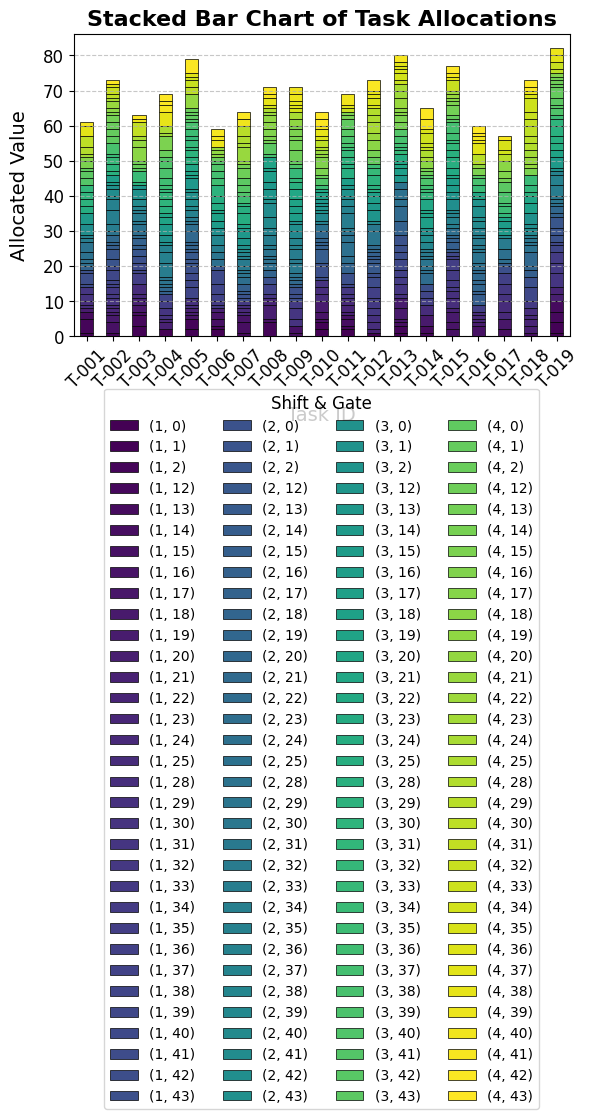

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Prepare data for stacked bar chart
stacked_data = optimized_allocation.groupby(['Task_ID', 'Shift_no', 'Gate_number'])['Allocated'].sum().reset_index()

# Pivot to prepare for stacking
stacked_pivot = stacked_data.pivot_table(
    values='Allocated',
    index='Task_ID',
    columns=['Shift_no', 'Gate_number'],
    aggfunc='sum'
).fillna(0)

# Create figure with adjusted size to accommodate bottom legend
plt.figure(figsize=(15, 10))

# Plot the stacked bar chart
stacked_pivot.plot(
    kind='bar',
    stacked=True,
    colormap='viridis',
    linewidth=0.5,
    edgecolor='black'
)

# Add chart details
plt.title('Stacked Bar Chart of Task Allocations', fontsize=16, weight='bold')
plt.xlabel('Task ID', fontsize=14, labelpad=10)
plt.ylabel('Allocated Value', fontsize=14, labelpad=10)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Move legend to bottom and adjust its parameters
plt.legend(
    title='Shift & Gate',
    fontsize=10,
    title_fontsize=12,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4  # Adjust number of columns in legend
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
# Explain what the graph conveys
print("\nWhat the stacked bar chart conveys:")
print("1. Each bar represents a specific Task_ID.")
print("2. The total height of each bar shows the overall allocated value for that task.")
print("3. The bar is divided into stacked sections, each corresponding to a Shift_no and Gate_number combination.")
print("   - This breakdown lets you see how different shifts and gates contribute to the allocation for each task.")
print("4. The color coding (from the colormap) helps visually distinguish between the different shifts and gates.")
# Adjust layout to accommodate bottom legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Increase bottom margin for legend

plt.show()


/var/folders/lf/c5b_4d3s14x09yk32w_qxhdh0000gn/T/ipykernel_3414/3966020833.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


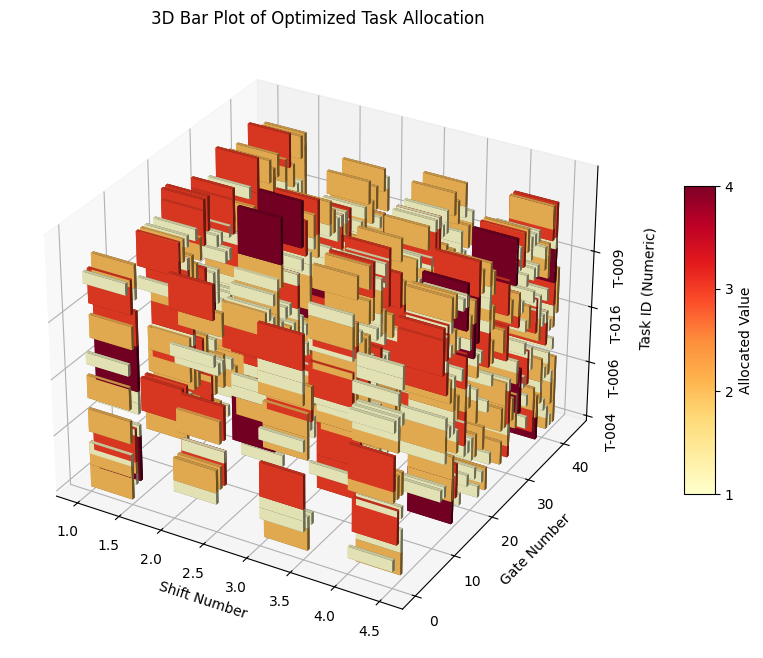

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np

# Convert Task_ID to numeric
optimized_allocation['Task_ID_numeric'] = pd.factorize(optimized_allocation['Task_ID'])[0]

# Extract numeric values
x = optimized_allocation['Shift_no']
y = optimized_allocation['Gate_number']
z = optimized_allocation['Task_ID_numeric']
allocated_values = optimized_allocation['Allocated']

# Normalize bar width
dx = dy = 0.5
dz = allocated_values

# Normalize colors based on Allocated values
norm = plt.Normalize(allocated_values.min(), allocated_values.max())
colors = plt.cm.YlOrRd(norm(allocated_values))

# Plot the 3D bars
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
bars = ax.bar3d(x, y, z, dx, dy, dz, color=colors)

# Set labels and title
ax.set_xlabel('Shift Number')
ax.set_ylabel('Gate Number')
ax.set_zlabel('Task ID (Numeric)')
ax.set_title('3D Bar Plot of Optimized Task Allocation')

# Add Task_ID labels with spacing to avoid overlap
task_id_labels = optimized_allocation.drop_duplicates('Task_ID_numeric')[['Task_ID_numeric', 'Task_ID']]
ax.set_zticks(task_id_labels['Task_ID_numeric'][::5])  # Show every 5th label
ax.set_zticklabels(task_id_labels['Task_ID'][::5], fontsize=10, rotation=90)  # Adjust font and rotation

# Add a color legend for Allocated values with integer ticks
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Allocated Value')

# Set integer ticks for the colorbar
int_ticks = np.arange(allocated_values.min(), allocated_values.max() + 1, 1)  # Ensure integer ticks
cbar.set_ticks(int_ticks)
cbar.set_ticklabels([str(tick) for tick in int_ticks])  # Convert to strings for display

plt.tight_layout()
plt.show()
